# 주제 : 아마존 푸드 리뷰 데이터 감성 분석 모델 및 요약문 추출 모델 구현
데이터 정보 : Kaggle의 Amazon food reviews data

데이터 및 주제 선정 이유
1. 커머스를 운영하는 기업의 입장에서 고객의 pain point가 무엇인지 파악하기 위해서 고객 리뷰 데이터에 주목함.
2. 엄청나게 쌓이는 리뷰 데이터를 모두 확인하고 분류하는데  많은 시간과 비용이듬. 이를 자동화하여 비용을 줄이기 위함.
3. 가장 많이 쌓이고 빈번하게 발생하는 클레임건들을 바탕으로 업무의 우선순위(개발팀의 개발 우선 순위)를 정하는데 이용할 수 있음.
4. 종합적으로, 서비스를 이용하는 고객님들의 입장에서 느껴지는 자사 플랫폼의 약점을 보완하는데 사용하고자 함.(ex. 제품, 배송서비스, CS 등)

데이터 분석 프로세스
1. EDA 및 데이터 전처리
2. 첫번째 모델 : 고객 평점을 바탕으로 5점을 받은 리뷰 텍스트는 긍정, 4점 이하를 받은 리뷰 텍스트는 부정으로 이진 분류 모델 구현
이유 : 고객님들이 평점 5점을 주는 경우, 모든 제품과 서비스에 만족을 했거나 혹은 의미없이 주는 경우가 있다고 생각하였음. 반면에, 4점 이하의 경우, 불만족하는 요소가 적어도 한개 이상이 있을 것이라 생각하여 부정으로 처리한 것임.
3. 두번째 모델 : 리뷰 텍스트와 요약문을 라벨링한 데이터들을 바탕으로 요약문 추출 모델 구현
4. 첫번째 모델에서 부정으로 분류된 리뷰 텍스트들을 두번째 모델의 데이터로 넣어 부정적인 요소를 요약할 수 있는 요약문 모델로 활용

핵심키워드 : NLP, 랜덤포레스트, XGboost, LSTM, Attention 등


# 첫번째 모델 : 리뷰 텍스트 감성 분석 모델 구현

### 1. 데이터 및 라이브러리 호출

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,657 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160837 files and d

In [2]:
pip install beautifulsoup4

In [3]:
# API Token 다운받기
# 다운받은 API Token 업로드 하기
!pip install kaggle
from google.colab import files
files.upload()
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# json 파일 제대로 업로드 됐는지 확인
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list
# 데이터셋 다운로드 받기 - 링크는 그 대회 'Data'에 있음
!kaggle datasets download -d snap/amazon-fine-food-reviews
# 다운로드 된 것들 다 보기 
!ls
# 필요하면 압축 풀기 


Saving kaggle.json to kaggle.json
ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes        234           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        404           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge       1048           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       6826           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      58267           False  
house-prices-advanced-regression-techniques          203

In [4]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [5]:
pip install transformers

     |████████████████████████████████| 2.6 MB 29.9 MB/s 
     |████████████████████████████████| 636 kB 56.6 MB/s 
     |████████████████████████████████| 895 kB 47.1 MB/s 
     |████████████████████████████████| 3.3 MB 38.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os


import re
import warnings
warnings.filterwarnings(action = 'ignore')

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, recall_score, precision_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import chi2 as chi

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from transformers import BertTokenizer, BertModel
from urllib import request
request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
nltk.download('all')  

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

### 2. EDA 및 데이터 전처리

In [7]:
df = pd.read_csv('Reviews.csv')
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
df.isnull().sum() 
##결측치가 약간 있는 것으로 보인다. 하지만 데이터의 크기가 크기 때문에 drop하여 진행할 것이다.

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [10]:
# 구매 고객의 누적 리뷰 수량(전제 : 구매한 모든 고객은 리뷰를 쓴다.)
user_count = pd.DataFrame(df['UserId'].value_counts()).reset_index().rename(columns = {'index':'UserId', 'UserId':'counts'})
user_count

,UserId,counts
0,A3OXHLG6DIBRW8,448
1,A1YUL9PCJR3JTY,421
2,AY12DBB0U420B,389
3,A281NPSIMI1C2R,365
4,A1Z54EM24Y40LL,256
...,...,...
256054,A280HHBR92XUI0,1
256055,A29SMLAQ6NE6JA,1
256056,A7NJ6902UM76N,1
256057,A3BJINLY447GKN,1


In [11]:
print('재구매 고객 비율:', len(user_count[user_count['counts'] > 1]) / len(user_count))
print('일회성 구매 고객 비율:', len(user_count[user_count['counts'] == 1]) / len(user_count))
## 일회성 구매로 끝난 고객이 약 70퍼센트나 된다.

재구매 고객 비율: 0.3150367688696746
일회성 구매 고객 비율: 0.6849632311303254


리뷰를 남긴 유저의 수가 256,059명인 것을 확인할 수 있음. 하지만 그 중에서 재구매고객의 비율은 약 30%밖에 되지 않음.
그렇다면 일회성 구매 고객의 평균 평점과 재구매 고객의 평균 평점을 비교해본다면, 일회성 구매 고객의 평점이 상대적으로 낮고 재구매 고객의 평균 평점이 높지 않을까라는 가설을 세워본다.

In [12]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [13]:
# 구매 고객의 누적 리뷰 수량(전제 : 구매한 모든 고객은 리뷰를 쓴다.)
pro_count = pd.DataFrame(df['ProductId'].value_counts()).reset_index().rename(columns = {'index':'ProductId', 'ProductId':'counts'})
pro_count

,ProductId,counts
0,B007JFMH8M,913
1,B0026RQTGE,632
2,B002QWP8H0,632
3,B002QWP89S,632
4,B002QWHJOU,632
...,...,...
74253,B001MQB7Q2,1
74254,B000SARG90,1
74255,B001L7UOV6,1
74256,B003KSS41G,1


리뷰가 남아있는 제품이 총 74,258 종류인 것을 볼 수 있음.

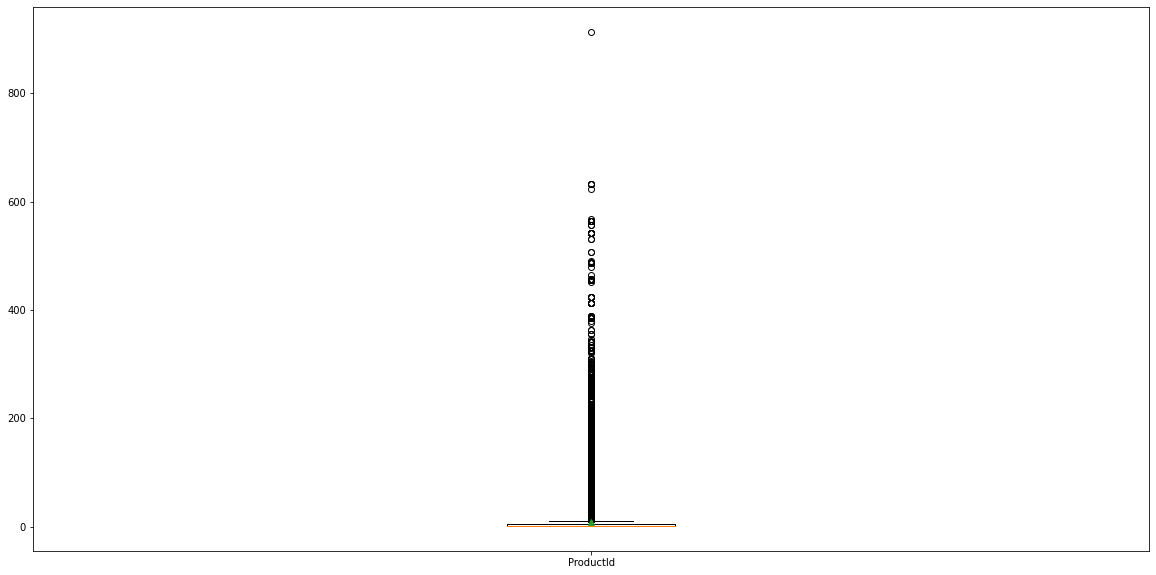

In [14]:
plt.figure(figsize = (20, 10))
plt.boxplot(pro_count['counts'], labels = ['ProductId'], showmeans = True)
plt.show()

In [ ]:
for i in range(1, 30):
    print(i,'개 구매한 리뷰의 비율', len(pro_count[pro_count['counts'] == i]) / len(pro_count))


1 개 구매한 리뷰의 비율 0.4094912332677961
2 개 구매한 리뷰의 비율 0.16512698968461312
3 개 구매한 리뷰의 비율 0.09223248673543591
4 개 구매한 리뷰의 비율 0.05822941635918016
5 개 구매한 리뷰의 비율 0.041813676640900646
6 개 구매한 리뷰의 비율 0.030124700368983813
7 개 구매한 리뷰의 비율 0.02479194160898489
8 개 구매한 리뷰의 비율 0.01917638503595572
9 개 구매한 리뷰의 비율 0.016011742842522016
10 개 구매한 리뷰의 비율 0.013480029087775054
11 개 구매한 리뷰의 비율 0.01093484877050284
12 개 구매한 리뷰의 비율 0.010126855018987854
13 개 구매한 리뷰의 비율 0.008591666891109375
14 개 구매한 리뷰의 비율 0.006921813137978399
15 개 구매한 리뷰의 비율 0.006598615637372404
16 개 구매한 리뷰의 비율 0.005238492822322174
17 개 구매한 리뷰의 비율 0.004888362196665679
18 개 구매한 리뷰의 비율 0.004443965633332435
19 개 구매한 리뷰의 비율 0.004039968757574942
20 개 구매한 리뷰의 비율 0.0034339734439387004
21 개 구매한 리뷰의 비율 0.0038918365697971934
22 개 구매한 리뷰의 비율 0.0024509143795954647
23 개 구매한 리뷰의 비율 0.0027875784427267097
24 개 구매한 리뷰의 비율 0.0023835815669692156
25 개 구매한 리뷰의 비율 0.002639446254948962
26 개 구매한 리뷰의 비율 0.002262382504241967
27 개 구매한 리뷰의 비율 0.00207385062888847
28 개 구매한 리뷰의 비

(array([7.3314e+04, 6.0600e+02, 1.7400e+02, 7.5000e+01, 4.7000e+01,
        2.4000e+01, 1.7000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  92.2, 183.4, 274.6, 365.8, 457. , 548.2, 639.4, 730.6,
        821.8, 913. ]),
 <a list of 10 Patch objects>)

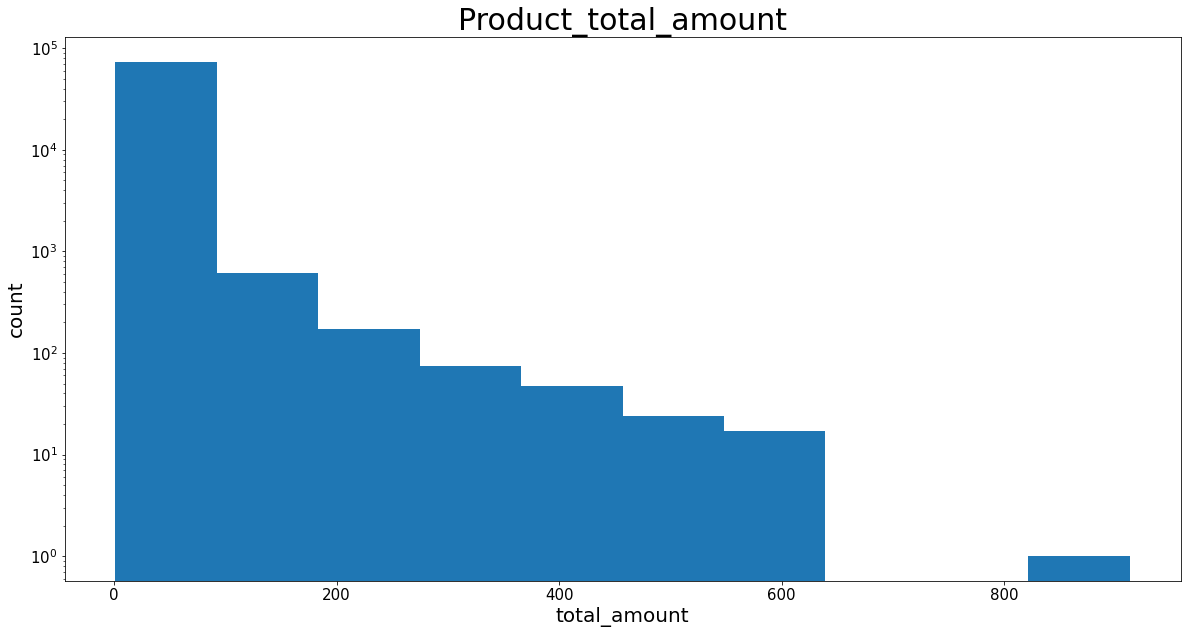

In [14]:
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('total_amount', fontsize = 20)
plt.ylabel('count', fontsize = 20)
plt.yscale('log')
plt.title('Product_total_amount', fontsize = 30)
plt.hist(pro_count['counts'])

In [ ]:
# df = pd.merge(df, pro_count, how = 'inner', on = 'ProductId')
# df

In [ ]:
#10개 이상이 있는 제품을 대상으로 모델링을 진행해보겠음. 그 이유는 리뷰가 소수인 것은 어느정도 다수의 의견이라고 판단하기엔 무리가 있다고 생각했기 떄문.
# df = df[df['counts'] > 10]
# df

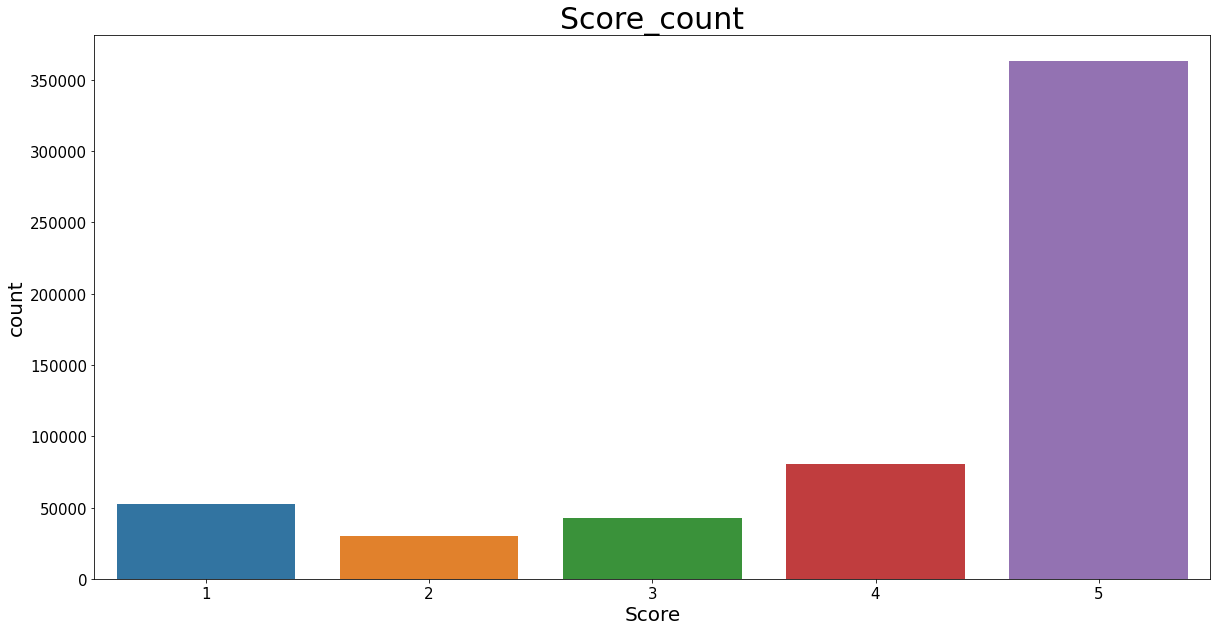

In [15]:
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('Score_count', fontsize = 30)
sns.countplot(x = 'Score', data = df)

5점에 대한 분포가 가장 높고 4점, 1점, 3점, 2점순으로 많은 것을 볼 수 있다. 이것을 데이터 전처리를 통해서 비율을 구해보겠음.

In [16]:
sent = []
def sent_score(data):
    for i in range(len(data)):
        if data['Score'][i] == 5:
            sent.append(1)
        else :
            sent.append(0)

    return sent

df['sentiment'] = sent_score(df)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,1
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,0
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,1


긍정 비율: 0.6387887146541321
부정 비율: 0.36121128534586794


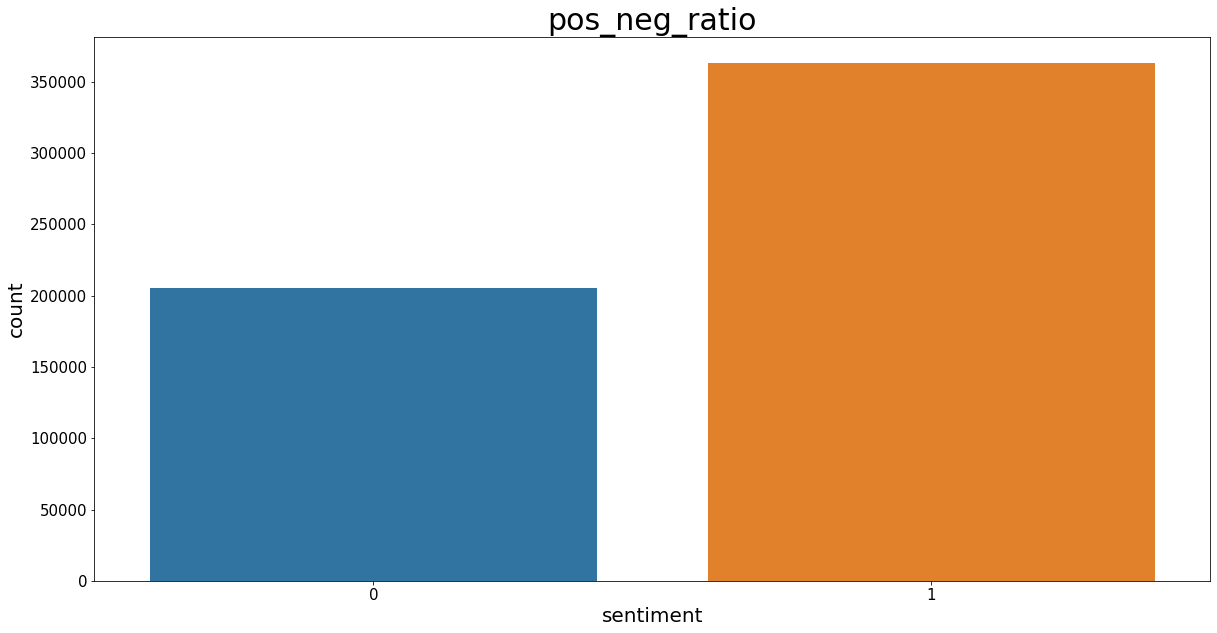

In [16]:
print('긍정 비율:', len(df[df['sentiment'] == 1]) / len(df))
print('부정 비율:', len(df[df['sentiment'] == 0]) / len(df))
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('pos_neg_ratio', fontsize = 30)
sns.countplot(df['sentiment'])

긍정과 부정의 비율이 어느정도 불균형적인 데이터라는 것을 확인할 수 있음. 그렇다면 오버 샘플링을 통해서 비율을 맞춰주도록 하겠다.

In [17]:
## 데이터 결측치 제거했다.
df = df.dropna(axis = 0)
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
sentiment                 0
dtype: int64

In [18]:
train = df[['Text', 'Summary', 'sentiment']]
train

,Text,Summary,sentiment
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,1
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,0
2,This is a confection that has been around a fe...,"""Delight"" says it all",0
3,If you are looking for the secret ingredient i...,Cough Medicine,0
4,Great taffy at a great price. There was a wid...,Great taffy,1
...,...,...,...
568449,Great for sesame chicken..this is a good if no...,Will not do without,1
568450,I'm disappointed with the flavor. The chocolat...,disappointed,0
568451,"These stars are small, so you can give 10-15 o...",Perfect for our maltipoo,1
568452,These are the BEST treats for training and rew...,Favorite Training and reward treat,1


In [19]:
## 데이터의 문장 길이 시긱화
def length_text(data, title):
    print('길이의 최댓값:{}'.format(np.max(data)))
    print('길이의 최솟값:{}'.format(np.min(data)))
    print('길이의 평균값:{}'.format(np.mean(data)))
    print('길이의 표준편차:{}'.format(np.std(data)))
    print('길이의 중간값:{}'.format(np.median(data)))

    plt.figure(figsize = (20, 10))
    plt.hist(data, bins = 200, alpha = 0.5, color = 'r', label = 'word')
    plt.yscale('log', nonposy = 'clip')
    plt.title(title, fontsize = 30)
    plt.xlabel('Length of Review', fontsize = 20)
    plt.ylabel('Number of Review', fontsize = 20)
    
    return plt.show()

## 데이터의 사분위 값 시각화
def length_text2(data, title):
    print('길이의 최댓값:{}'.format(np.max(data)))
    print('길이의 최솟값:{}'.format(np.min(data)))
    print('길이의 평균값:{}'.format(np.mean(data)))
    print('길이의 표준편차:{}'.format(np.std(data)))
    print('길이의 중간값:{}'.format(np.median(data)))

    plt.figure(figsize = (20, 10))
    plt.boxplot(data, labels = ['counts'], showmeans = True)
    plt.title(title, fontsize = 30)

    return plt.show()

## 단어 빈도 수 시각화
def text_size(data):
    data_review = [review for review in data if type(review) is str]
    wordcloud = WordCloud('NanumGothic.ttf').generate(' '.join(data_review))
    plt.figure(figsize = (20, 10))
    plt.title('Word frequency', fontsize = 30)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    return plt.show()


In [20]:
length = train['Text'].astype('str').apply(len)
train_word_counts = train['Text'].astype(str).apply(lambda x : len(x.split(' ')))

길이의 최댓값:21409
길이의 최솟값:12
길이의 평균값:436.2414819558383
길이의 표준편차:445.3488563770343
길이의 중간값:302.0


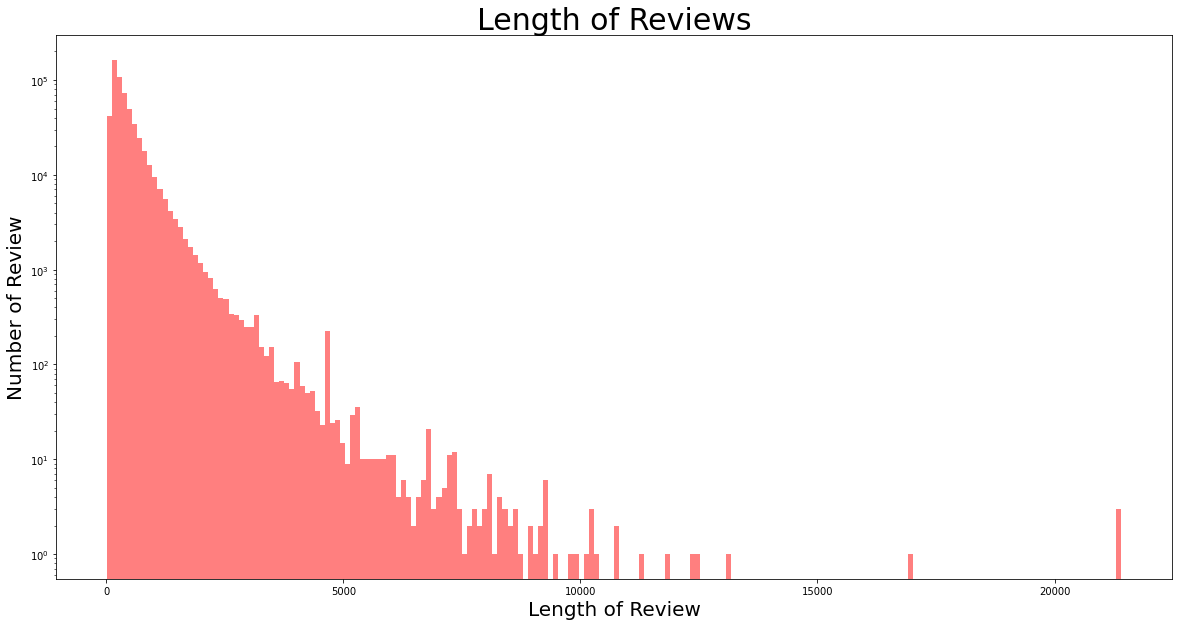

In [21]:
length_text(length, 'Length of Reviews')

길이의 최댓값:21409
길이의 최솟값:12
길이의 평균값:436.2414819558383
길이의 표준편차:445.3488563770343
길이의 중간값:302.0


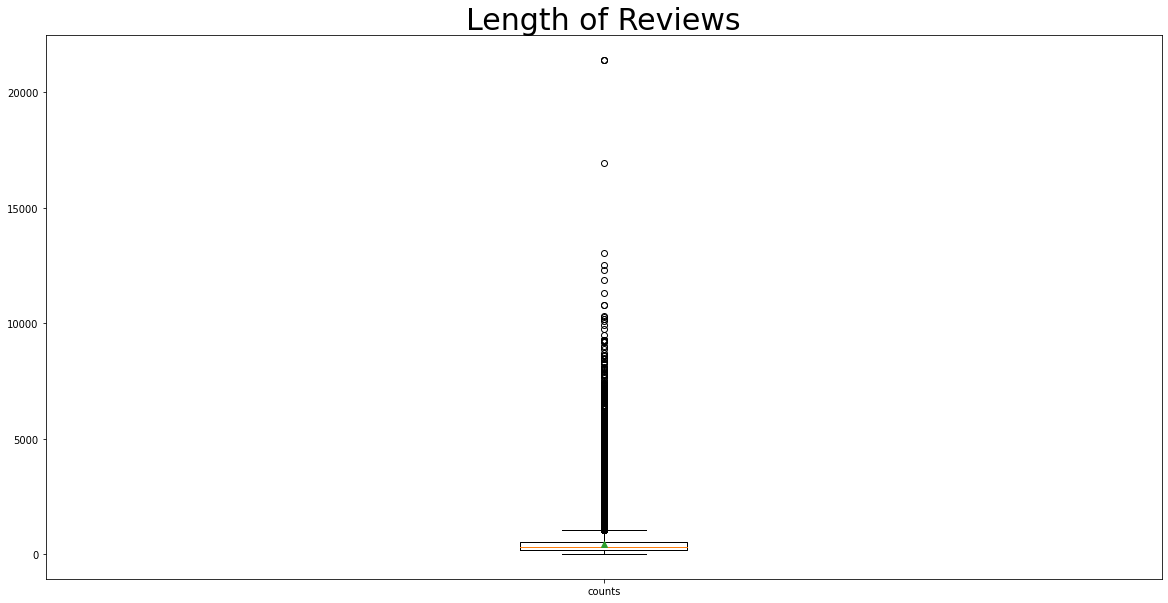

In [22]:
length_text2(length, 'Length of Reviews')

길이의 최댓값:3526
길이의 최솟값:3
길이의 평균값:82.00894951012559
길이의 표준편차:80.80877233446446
길이의 중간값:58.0


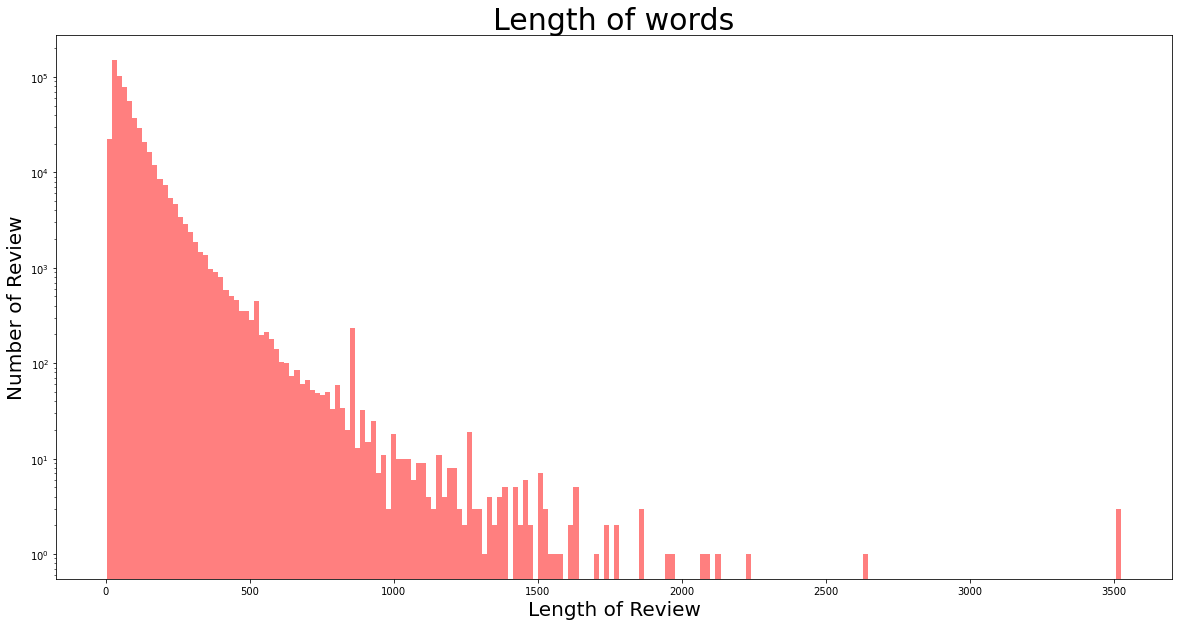

In [23]:
length_text(train_word_counts, 'Length of words')

길이의 최댓값:3526
길이의 최솟값:3
길이의 평균값:82.00894951012559
길이의 표준편차:80.80877233446446
길이의 중간값:58.0


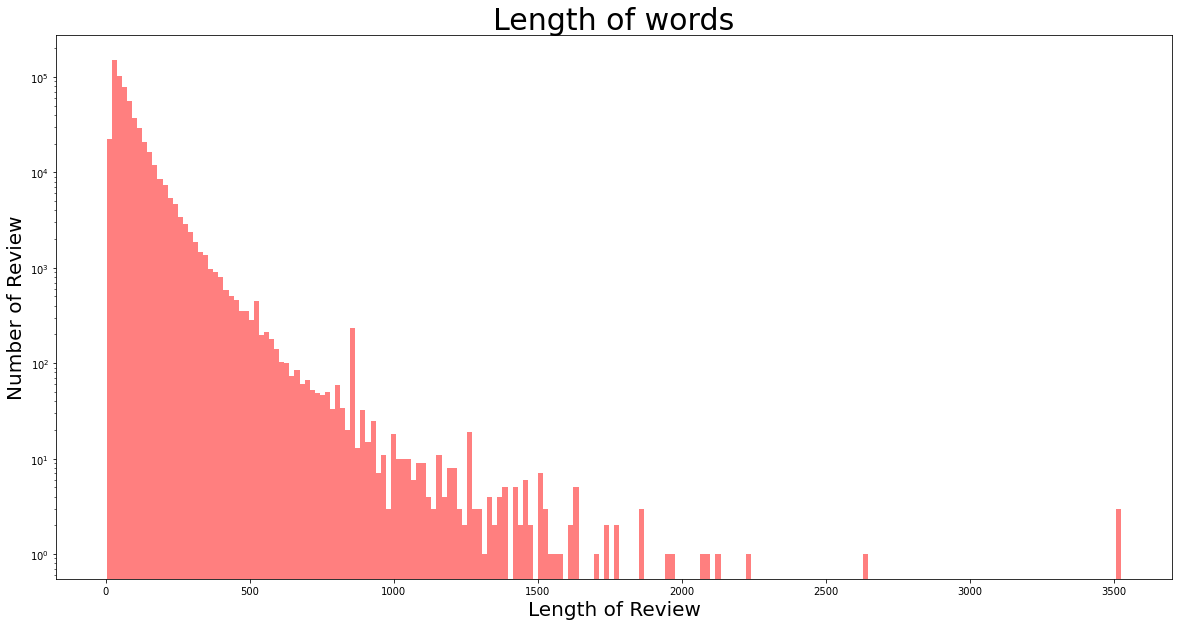

In [24]:
length_text(train_word_counts, 'Length of words')

이상치가 많은 것을 볼 수 있다. 

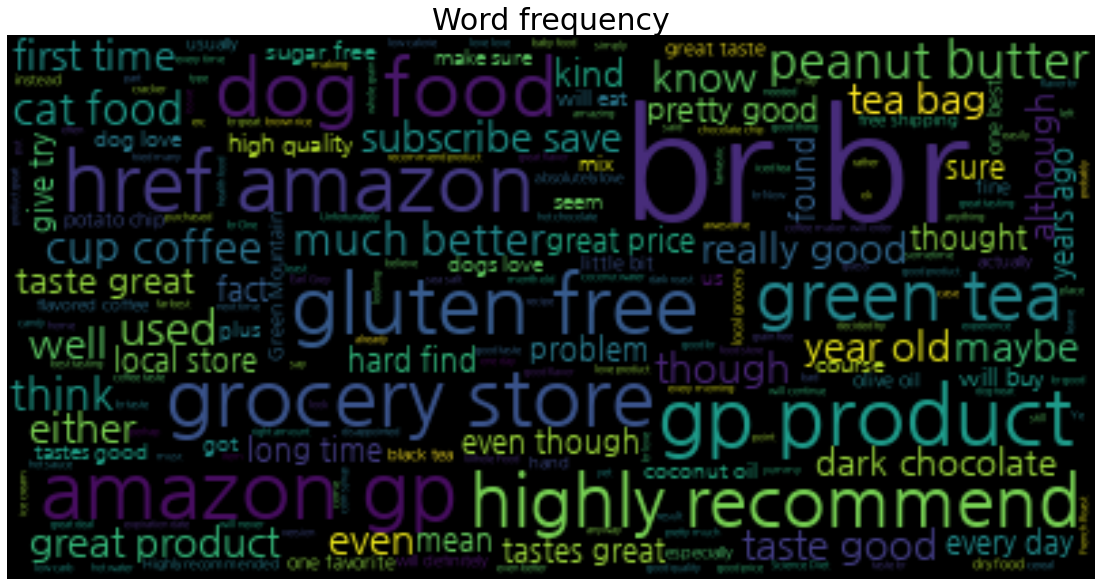

In [ ]:
text_size(train['Text'])

HTML 요소인 br의 빈도가 많은 것을 볼 수 있다. beautiful soup를 활용하여 전처리를 할 예정이다.

In [25]:
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'aren', 'i', 'off', "hasn't", 'up', 'very', 'm', 'be', 'she', "couldn't", 'ours', 'a', 'doing', 'what', 'during', 'your', 'hadn', 'while', 'more', 'such', 'other', 'am', 'mightn', 'because', "you'll", 'd', "you're", 'is', 'no', 'or', 'should', 'didn', 'herself', 'about', 'in', 'when', 'too', 'once', 'which', 'these', 'we', 'further', 'why', 'needn', 'an', 'me', 'had', 'will', 'his', 'than', "you'd", 'mustn', "wasn't", 'some', 'this', 'own', 'above', 'each', 'same', "hadn't", "didn't", "wouldn't", 'not', 'having', 'him', "it's", 'them', 'at', 'ma', 'through', 'o', 'to', "aren't", 'any', 'can', 'my', 'was', 'only', 'those', "won't", 'down', 'the', 'who', "don't", 'under', 'does', 'are', 'few', 've', 'against', 'you', 'has', "mustn't", 'don', 'both', 'shouldn', "shan't", 'theirs', 'into', 'yourself', 'doesn', 'himself', 'they', 'its', 'after', 'll', 'by', 'isn', 'most', 'just', "she's", 'with', "mightn't", 'below', 'he', "haven't", 'won', 's', 'nor', 'on', 'weren', "that'll"

In [26]:
def clean_text(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

텍스트 전처리에서 실행이 된다고 해서 무조건 되는 것이 아니라 순서나 리스트 형태에 따라 전처리가 제대로 안되어 있을 수 있다.
이 전에는 정규 표현식을 우선적으로 했지만, 그렇게 하다보니 불용어에서 미처 처리되지 않는 단어들이 있었다.
그래서 불용어 처리를 우선적으로 진행해주었다.

In [27]:
train['Text'] = train['Text'].apply(clean_text)
train['Text']

0         bought several vitality canned dog food produc...
1         product arrived labeled jumbo salted peanuts p...
2         confection around centuries light pillowy citr...
3         looking secret ingredient robitussin believe f...
4         great taffy great price wide assortment yummy ...
                                ...                        
568449    great sesame chicken good better resturants ea...
568450    disappointed flavor chocolate notes especially...
568451    stars small give one training session tried tr...
568452    best treats training rewarding dog good groomi...
568453    satisfied product advertised use cereal raw vi...
Name: Text, Length: 568411, dtype: object

In [28]:
length_eda = train['Text'].astype('str').apply(len)
train_word_counts_eda = train['Text'].astype(str).apply(lambda x : len(x.split(' ')))

길이의 최댓값:14368
길이의 최솟값:0
길이의 평균값:251.33744948637516
길이의 표준편차:253.83664638453783
길이의 중간값:175.0


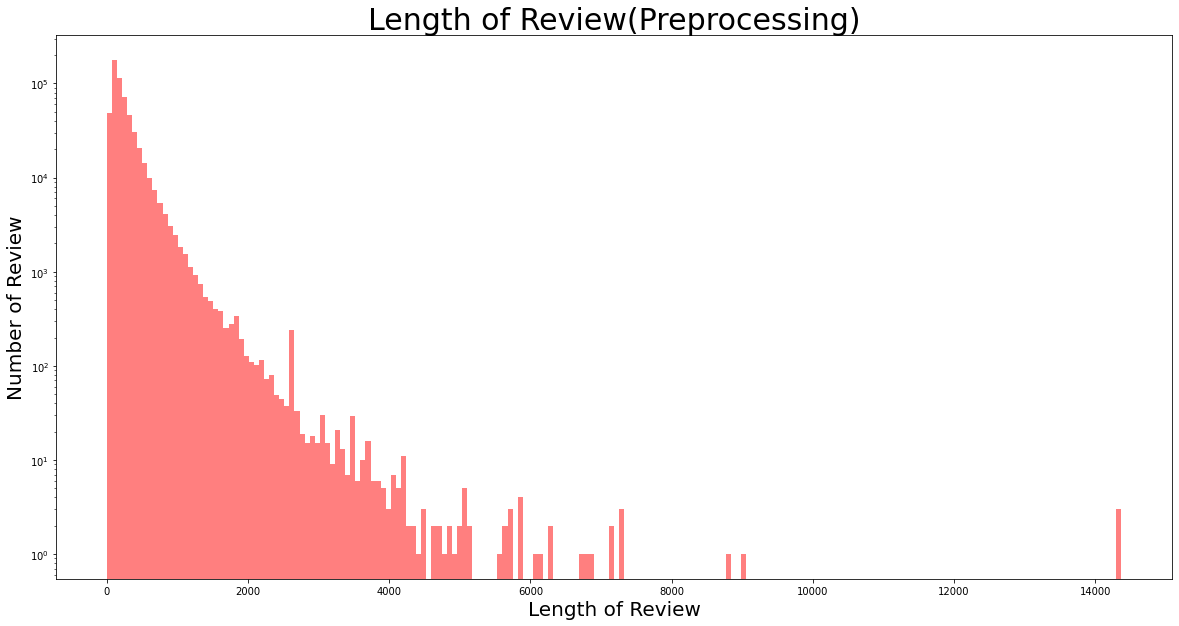

In [29]:
length_text(length_eda, 'Length of Review(Preprocessing)')

길이의 최댓값:14368
길이의 최솟값:0
길이의 평균값:251.33744948637516
길이의 표준편차:253.83664638453783
길이의 중간값:175.0


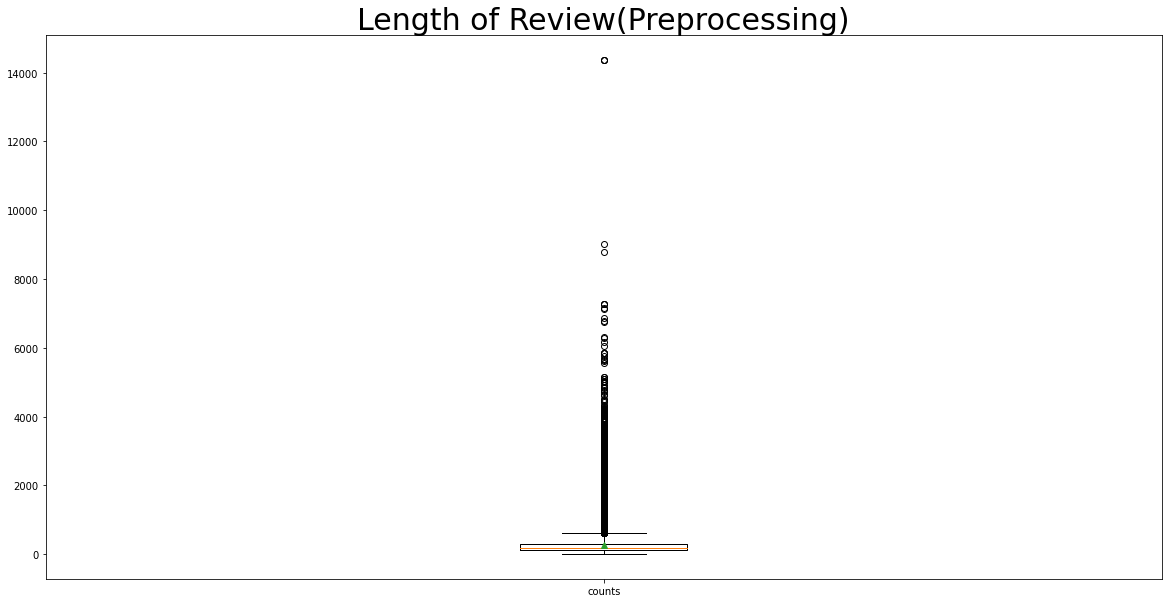

In [30]:
length_text2(length_eda, 'Length of Review(Preprocessing)')

In [31]:
train['length'] = train['Text'].apply(lambda x : len(x)) ## 최솟값이 0으로 나오기 때문에 0인값을 추출해본다.
train[train['length'] == 0]

,Text,Summary,sentiment,length
188001,,good,1,0
233938,,&#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#11...,1,0
299605,,good,1,0
324249,,good,1,0
378643,,W A R N I N IN G,1,0
388831,,good,1,0
487863,,good,1,0
544869,,good,1,0


길이의 최댓값:1918
길이의 최솟값:1
길이의 평균값:38.117443188115644
길이의 표준편차:37.47852758275714
길이의 중간값:27.0


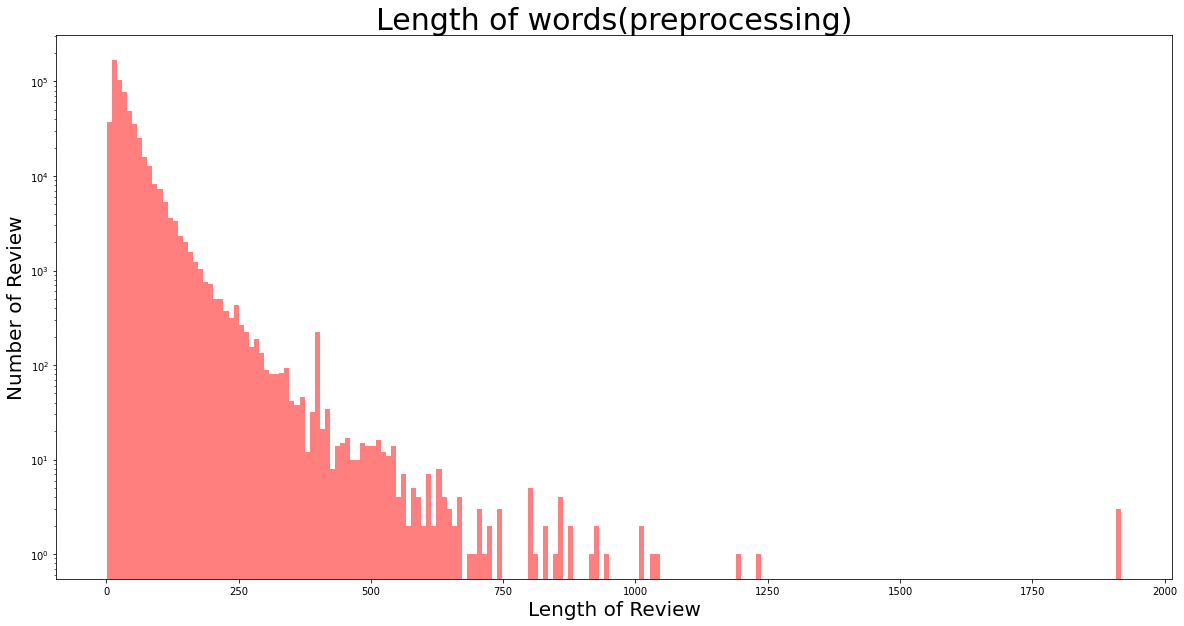

In [32]:
length_text(train_word_counts_eda, 'Length of words(preprocessing)')

길이의 최댓값:1918
길이의 최솟값:1
길이의 평균값:38.117443188115644
길이의 표준편차:37.47852758275714
길이의 중간값:27.0


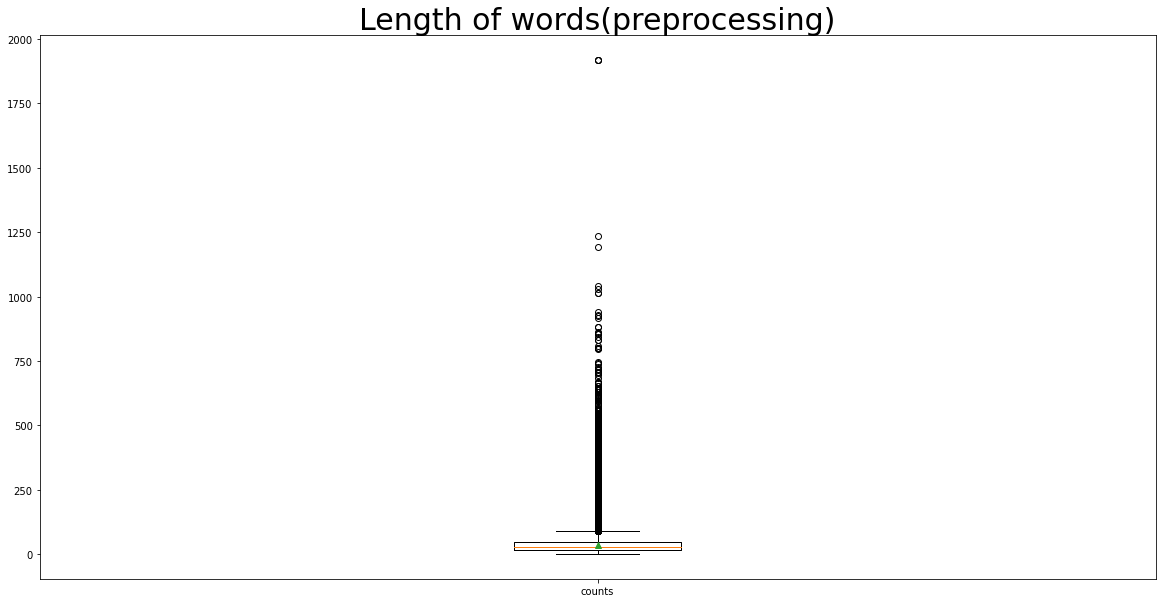

In [33]:
length_text2(train_word_counts_eda, 'Length of words(preprocessing)')

In [34]:
print('3사분위', train['length'].quantile(0.75))
print('95%', train['length'].quantile(0.95))
print('50%', train['length'].quantile(0.5))
print('5%', train['length'].quantile(0.05))
## 전처리를 진행하면서 너무 작아진 값은 의미 자체가 사라질 수 있기 때문에 이상치를 제거해줌.

3사분위 304.0
95% 687.0
50% 175.0
5% 62.0


길이의 최댓값:14368
길이의 최솟값:0
길이의 평균값:251.33744948637516
길이의 표준편차:253.83664638453783
길이의 중간값:175.0


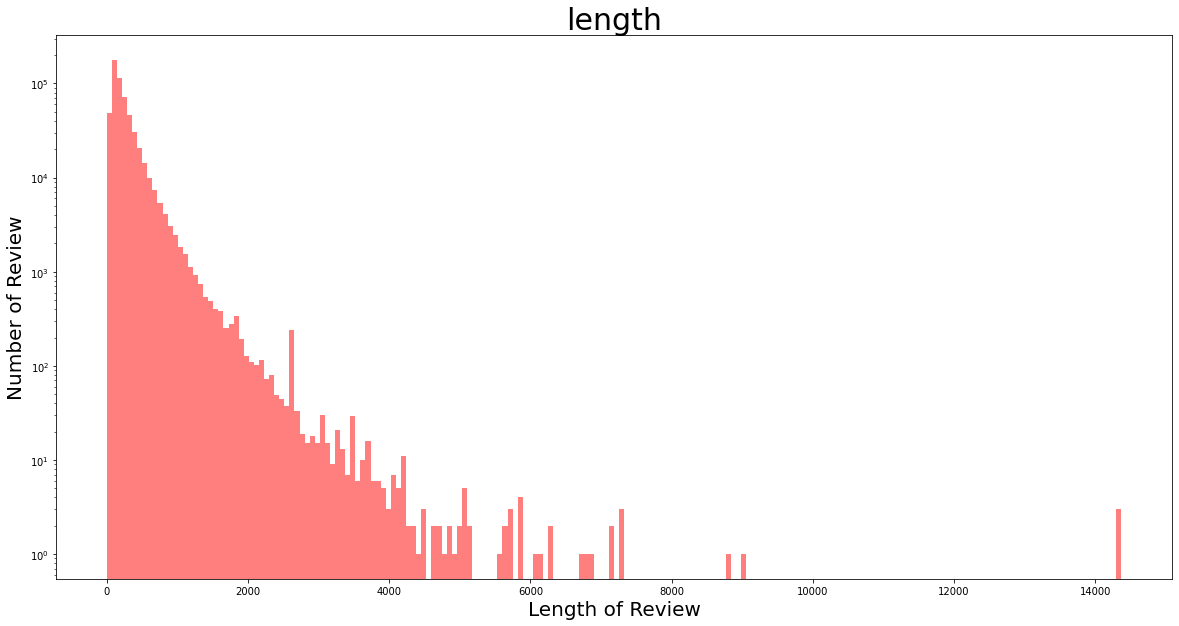

In [35]:
length_text(train['length'], 'length')

In [36]:
train = train[train['length'] > 66] #길이가 하위 5% 이상인 것만 넣어주었음.
train = train.sort_values('length')
train

,Text,Summary,sentiment,length
382751,sometimes hard time finding store found online...,Very Good,1,67
197826,van houtte chocolate raspberry truffle lack ra...,raspberry truffle lack the rasberry taste,0,67
336319,great deal first bought dog loves treats serve...,My dog loves these!,0,67
306033,moldy smell taste much raspberry flavor added ...,has a moldy smell,0,67
279413,much say review fruit loops love like move rus...,How could you not enjoy Fruit Loops?,1,67
...,...,...,...,...
68700,update read update first thanks four cats two ...,SEARCHING FOR A PET APPETITE ENHANCER?,1,8769
346183,tea antioxidants antioxidants help body protec...,Tea Antioxidants,1,9022
290807,fuzzy wuzzy summary somewhat recommended reser...,An okay filtered municipal tap water with slig...,0,14368
496753,fuzzy wuzzy summary somewhat recommended reser...,An okay filtered municipal tap water with slig...,0,14368


In [37]:
print('고유값의 수', train['Text'].nunique())
print('텍스트 중복 데이터 숫자', len(train) - train['Text'].nunique())
print('완전 중복 데이터 수', len(train[train.duplicated()]))
### 고유값과 완정중복 데이터 사이에서 약간의 차이가 있는 것으로 보여진다. 

고유값의 수 368010
텍스트 중복 데이터 숫자 163391
완전 중복 데이터 수 161737


In [38]:
train = train.drop_duplicates()
train.shape

(369664, 4)

긍정 비율: 0.6336538045360111
부정 비율: 0.36634619546398894


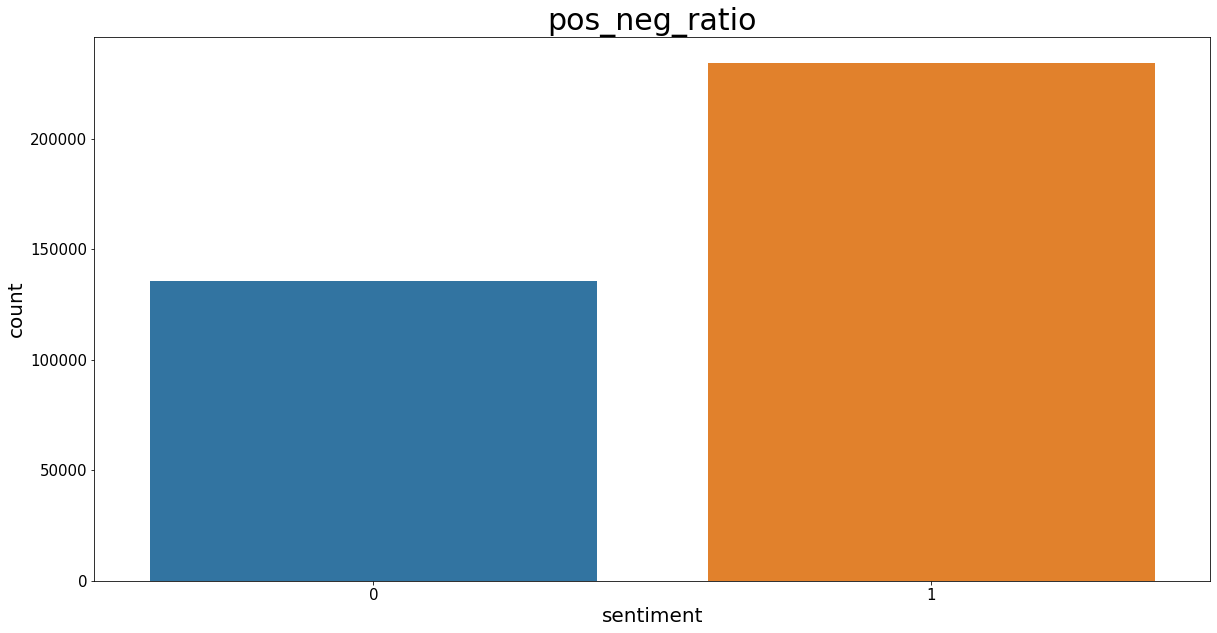

In [39]:
print('긍정 비율:', len(train[train['sentiment'] == 1]) / len(train))
print('부정 비율:', len(train[train['sentiment'] == 0]) / len(train))
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('pos_neg_ratio', fontsize = 30)
sns.countplot(train['sentiment'])

## 데이터 전처리를 통해서 불필요한 데이터를 제거해준 후, 비율을 확인
## 이전과 유사한 형태의 비율이 띈다. 벡터화를 진행한 후, 오버샘플링을 진행할 예정

In [40]:
token = Tokenizer()
token.fit_on_texts(train['Text'])

threshold = 7
total_cnt = len(token.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in token.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 121238
등장 빈도가 6번 이하인 희귀 단어의 수: 92208
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 29030
단어 집합에서 희귀 단어의 비율: 76.05536218017454
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0619905747641283


In [41]:
def token(data, leng, max_feature):
    token = Tokenizer(num_words=max_feature)
    token.fit_on_texts(data)
    sequences = token.texts_to_sequences(data)
    sequences = pad_sequences(sequences, maxlen= leng, padding = 'post')
    word_index = token.word_index
    
    return sequences, word_index

In [42]:
X_train, vocab = token(train['Text'], 300, 30000)
y_train = train['sentiment']
X_train, vocab

(array([[  375,   111,    19, ...,     0,     0,     0],
        [ 4134,  5437,    31, ...,     0,     0,     0],
        [    5,   283,    33, ...,     0,     0,     0],
        ...,
        [  437,    14,  8795, ...,   585,     2,  1412],
        [  357,  3524,  8943, ...,  1336,  1251,     9],
        [ 2467,   618,   826, ...,    15, 23173,   237]], dtype=int32),
 {'like': 1,
  'good': 2,
  'taste': 3,
  'one': 4,
  'great': 5,
  'product': 6,
  'flavor': 7,
  'coffee': 8,
  'tea': 9,
  'would': 10,
  'love': 11,
  'get': 12,
  'really': 13,
  'food': 14,
  'much': 15,
  'amazon': 16,
  'use': 17,
  'also': 18,
  'time': 19,
  'little': 20,
  'buy': 21,
  'make': 22,
  'price': 23,
  'find': 24,
  'best': 25,
  'well': 26,
  'tried': 27,
  'even': 28,
  'better': 29,
  'try': 30,
  'chocolate': 31,
  'eat': 32,
  'first': 33,
  'sugar': 34,
  'water': 35,
  'used': 36,
  'found': 37,
  'sweet': 38,
  'made': 39,
  'drink': 40,
  'bag': 41,
  'box': 42,
  'bought': 43,
  'cup': 44,


In [43]:
X_train.shape, y_train.shape

((369664, 300), (369664,))

### LSTM 감성 분석 모델 구현

In [ ]:
model_name = 'lstmmodel'
batch_size = 256
num_epochs = 30
max_features = 30000

kargs = {'model_name' : model_name,
         'vocab_size' : max_features,
         'embedding_dimension' : 128,
         'dropout_rate' : 0.2,
         'lstm_dimension' : 256,
         'dense_dimension' : 256,
         'output_dimension' : 1}


class LstmModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(LstmModel, self).__init__(name=kargs['model_name'])
        self.embedding = tf.keras.layers.Embedding(input_dim = kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc1 = tf.keras.layers.Dense(units = kargs['dense_dimension'], activation=tf.keras.activations.relu)
        self.fc2 = tf.keras.layers.Dense(units = kargs['output_dimension'], activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    model = LstmModel(**kargs)
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.72.252.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.252.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state =411)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((295731, 300), (73933, 300), (295731,), (73933,))

In [ ]:
model_name = "lstm"

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
        
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

history = model.fit(X_train, y_train, epochs = num_epochs, batch_size=128, validation_split=0.2, callbacks=[es, cp_callback])

lstm -- Folder create complete 

Epoch 1/30


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


1849/1849 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.6344

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


1849/1849 [==============================] - 215s 110ms/step - loss: 0.6573 - accuracy: 0.6344 - val_loss: 0.6584 - val_accuracy: 0.6341

Epoch 00001: val_loss improved from inf to 0.65843, saving model to lstm/weights.h5
Epoch 2/30
1849/1849 [==============================] - 198s 107ms/step - loss: 0.6569 - accuracy: 0.6345 - val_loss: 0.6567 - val_accuracy: 0.6341

Epoch 00002: val_loss improved from 0.65843 to 0.65673, saving model to lstm/weights.h5
Epoch 3/30
1849/1849 [==============================] - 198s 107ms/step - loss: 0.6567 - accuracy: 0.6347 - val_loss: 0.6567 - val_accuracy: 0.6343

Epoch 00003: val_loss improved from 0.65673 to 0.65669, saving model to lstm/weights.h5
Epoch 4/30
1849/1849 [==============================] - 198s 107ms/step - loss: 0.6563 - accuracy: 0.6350 - val_loss: 0.6572 - val_accuracy: 0.6341

Epoch 00004: val_loss did not improve from 0.65669
Epoch 5/30
1849/1849 [==============================] - 198s 107ms/step - loss: 0.6557 - accuracy: 0.635

In [ ]:
lstm_acc = model.evaluate(X_test, y_test)
lstm_acc

2311/2311 [==============================] - 52s 22ms/step - loss: 0.5030 - accuracy: 0.8027


[0.5030092597007751, 0.8027403354644775]

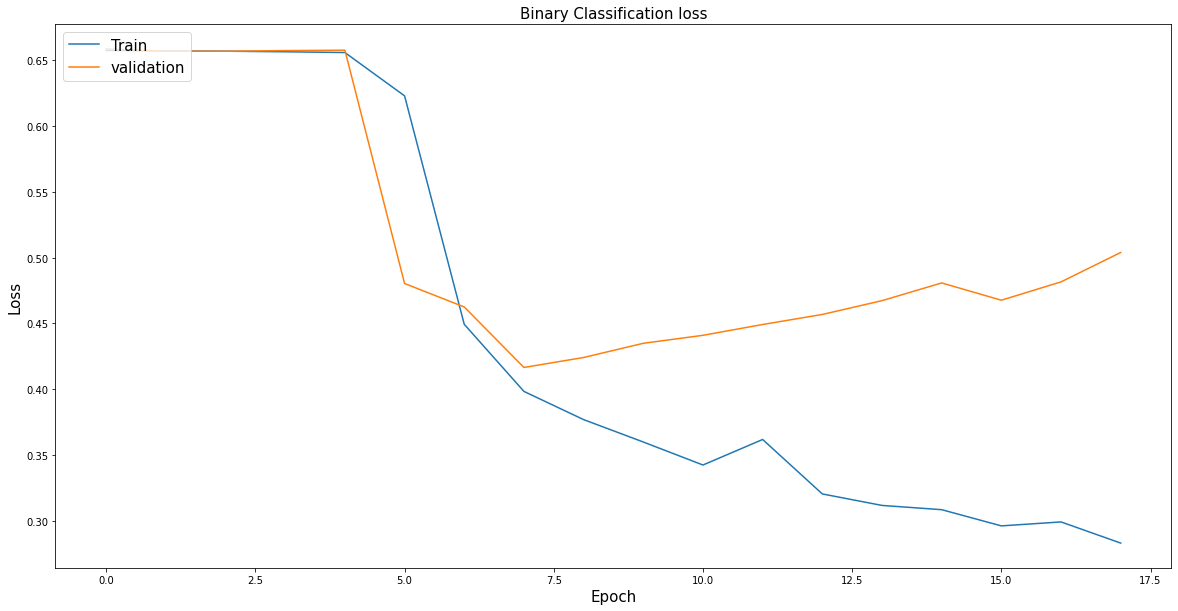

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Classification loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

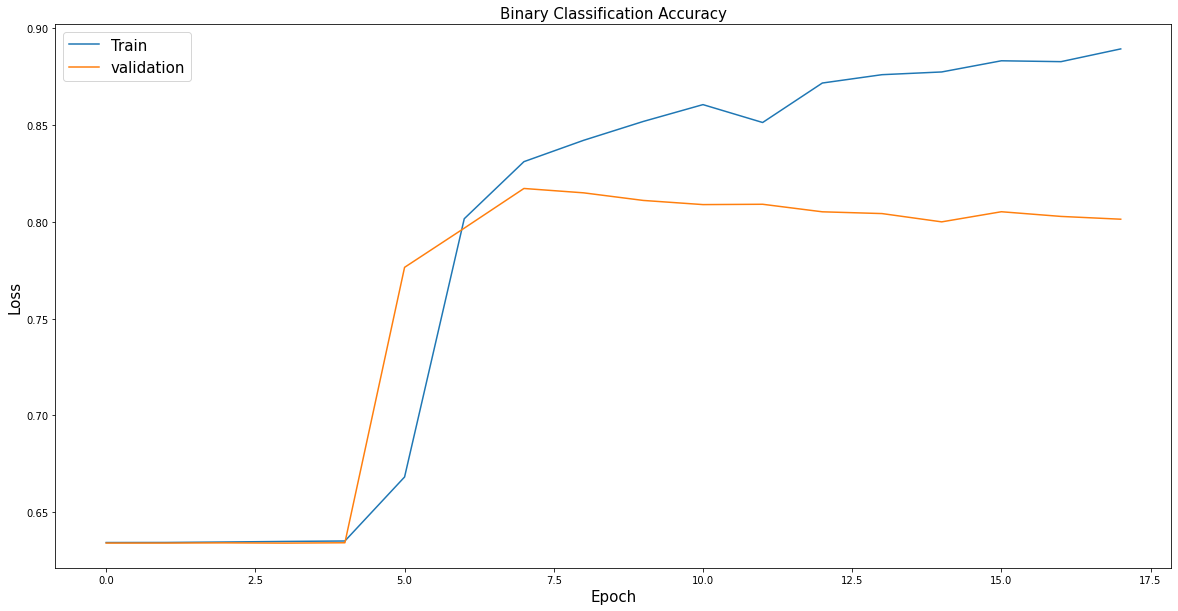

In [ ]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Binary Classification Accuracy', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

Local minima에 빠져있다가 벗어나는 것을 확인하였다. 베이스 라인 모델로 0.8이 나온 것은 나쁘지 않은 것으로 볼 수 있다.

### 앙상블(TF-IDF) 감성 분석 모델 구현

In [46]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(train['Text'], train['sentiment'], test_size=0.2, random_state=411)

In [52]:
## 1. 랜덤포레스트 활용
vect = TfidfVectorizer(stop_words='english',
                       max_df=0.7,
                       min_df = 3)

rfc = RandomForestClassifier(random_state = 411)

# svd = TruncatedSVD(algorithm='randomized'
#                    , n_iter=5
#                    , random_state=2)

chi = SelectKBest(chi2, k = 15000)

pipe = Pipeline([
    ('vect', vect),
    ('chi', chi),
    ('clf', rfc)
])

pipe

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=None,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [53]:
pipe.fit(X_train_tf, y_train_tf)
print('랜덤포레스트 학습 정확도:', pipe.score(X_train_tf, y_train_tf))
print('랜덤포레스트 테스트 정확도:', pipe.score(X_test_tf, y_test_tf))

랜덤포레스트 학습 정확도: 0.999790350014033
랜덤포레스트 테스트 정확도: 0.7954228828804458


In [54]:
parameters = {
    'vect__max_df': (0.7, 1.0) # document frequency(%) 높을 경우 제거
    ,'vect__min_df': (2, 5, 10) # document frequency(횟수) 낮을 경우 제거
    ,'vect__max_features': (10000, 15000) # 코퍼스에서 term frequency 높은 순서대로 나열하여 제한
    ,'clf__n_estimators': (50, 100) # The number of trees in the forest.
    ,'clf__max_depth': (5, 8, 12, None) # The maximum depth of the tree
}

grid_cv = GridSearchCV(pipe,
                       parameters, 
                       cv=3,
                       n_jobs=-1, 
                       verbose=1,
                       scoring = 'accuracy',
                       refit = True)

grid_cv.fit(X_train_tf, y_train_tf)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 489.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.7,
                                                        max_features=None,
                                                        min_df=3,
                                                        ngram_range=(1, 1),
                                                        no

In [55]:
grid_cv.best_score_, grid_cv.best_params_

(0.7917668421639936,
 {'clf__max_depth': None,
  'clf__n_estimators': 100,
  'vect__max_df': 0.7,
  'vect__max_features': 15000,
  'vect__min_df': 10})

In [56]:
y_pred_tf = grid_cv.best_estimator_.predict(X_test_tf)
rfc_proba = grid_cv.best_estimator_.predict_proba(X_test_tf)
rfc_acc = grid_cv.best_estimator_.score(X_test_tf, y_test_tf)
rfc_f1 = f1_score(y_test_tf, y_pred_tf)

y_pred = pipe.predict(X_test_tf)
pipe_f1 = f1_score(y_test_tf, y_pred)
print('랜덤포레스트 튜닝 전 accuracy', pipe.score(X_test_tf, y_test_tf))
print('랜덤포레스트 튜닝 전 f1_score', pipe_f1)
print('-------------------------------------')
print('-------------------------------------')
print('랜덤포레스트 모델 accuracy:', rfc_acc)
print('랜덤포레스트 모델 f1_score:', rfc_f1)
print('랜덤포레스트 모델 roc_auc_score:', roc_auc_score(y_test_tf, rfc_proba[:, 1]))
print('랜덤포레스트 모델 precision_score:', precision_score(y_test_tf, y_pred_tf))
print('랜덤포레스트 모델 recall_score:', recall_score(y_test_tf, y_pred_tf))

랜덤포레스트 튜닝 전 accuracy 0.7954228828804458
랜덤포레스트 튜닝 전 f1_score 0.8496894409937888
-------------------------------------
-------------------------------------
랜덤포레스트 모델 accuracy: 0.7940838326592996
랜덤포레스트 모델 f1_score: 0.8486649833992723
랜덤포레스트 모델 roc_auc_score: 0.853241422072968
랜덤포레스트 모델 precision_score: 0.7909687222057515
랜덤포레스트 모델 recall_score: 0.915440703409822


recall이 압도적으로 높은 것을 볼 수 있다. recall은 실제 1인 값 중에, 1로 예측할 확률이 높다라는 것을 볼 수 있다. 
반면에 precision은 상대적으로 낮은 것을 볼 수 있다. precision은 1로 예측한 값 중에 실제 1인 값으로 볼 수 있다. 
recall이 높은 이유를 생각해보면, 데이터의 불균형을 원인으로 볼 수 있다. 약 7:3의 비율로 1의 값이 많기 때문에 학습을 진행할 때 1에 대해 가중치가 높게 학습이 진행된 것으로 추론할 수 있다.
그래서 대부분의 값을 1로 예측하기 때문에, 실제 1인 값들을 1로 예측하는 것으로 볼 수 있다. 그래서 recall이 높게 나온다.
하지만, precision은 1로 예측한 값중에는 실제로 1이 아닌 값들도 섞이게 되는데, 불균형 데이터로 학습을 진행하다보니 1로 예측한 값들이 많지만, 그 중에서 1이 아닌 값들이 많아서 precision이 낮게 나오는 것으로 추론할 수 있다.


In [44]:
## 2. XGBoost 활용
vect = TfidfVectorizer(stop_words='english'
                        ,max_df=.7
                        ,min_df=3)

xgb = XGBClassifier(random_state = 411)

# svd = TruncatedSVD(algorithm='randomized'
#                    , n_iter=5
#                    , random_state=2)

chi = SelectKBest(chi, k = 15000)

pipe_xgb = Pipeline([
    ('vect', vect),
    ('chi', chi),
    ('xgb', xgb)
])

pipe_xgb

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=None,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                        

In [47]:
pipe_xgb.fit(X_train_tf, y_train_tf)
print('XGBoost 학습 정확도:', pipe_xgb.score(X_train_tf, y_train_tf))
print('XGBoost 테스트 정확도:', pipe_xgb.score(X_test_tf, y_test_tf))

XGBoost 학습 정확도: 0.7438685832733126
XGBoost 테스트 정확도: 0.7408870193283108


In [48]:
parameters = {
    'vect__max_df': (0.7, 1.0) # document frequency(%) 높을 경우 제거
    ,'vect__min_df': (2, 5, 10) # document frequency(횟수) 낮을 경우 제거
    ,'vect__max_features': (10000, 15000) # 코퍼스에서 term frequency 높은 순서대로 나열하여 제한
    ,'xgb__n_estimators': (50, 100) # The number of trees in the forest.
    ,'xgb__max_depth': (5, 8, 12, None) # The maximum depth of the tree
}

grid_xgb = GridSearchCV(pipe_xgb,
                       parameters, 
                       cv=3,
                       n_jobs=-1, 
                       verbose=1,
                       scoring = 'accuracy',
                       refit = True)

grid_xgb.fit(X_train_tf, y_train_tf)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 163.6min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 314.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.7,
                                                        max_features=None,
                                                        min_df=3,
                                                        ngram_range=(1, 1),
                                                        no

In [50]:
print(grid_xgb.best_score_, grid_xgb.best_params_)

y_pred_tf_xgb = grid_xgb.best_estimator_.predict(X_test_tf)
xgb_proba = grid_xgb.best_estimator_.predict_proba(X_test_tf)
xgb_acc = grid_xgb.best_estimator_.score(X_test_tf, y_test_tf)
xgb_f1 = f1_score(y_test_tf, y_pred_tf_xgb)

y_pred_xgb = pipe_xgb.predict(X_test_tf)
pipe_f1_xgb = f1_score(y_test_tf, y_pred_xgb)
print('XGBoost 튜닝 전 accuracy', pipe_xgb.score(X_test_tf, y_test_tf))
print('XGBoost 튜닝 전 f1_score', pipe_f1_xgb)
print('-------------------------------------')
print('-------------------------------------')
print('XGBoost 모델 accuracy:', xgb_acc)
print('XGBoost 모델 f1_score:', xgb_f1)
print('XGBoost 모델 roc_auc_score:', roc_auc_score(y_test_tf, xgb_proba[:, 1]))
print('XGBoost 모델 precision_score:', precision_score(y_test_tf, y_pred_tf_xgb))
print('XGBoost 모델 recall_score:', recall_score(y_test_tf, y_pred_tf_xgb))

0.7823866960176646 {'vect__max_df': 0.7, 'vect__max_features': 15000, 'vect__min_df': 5, 'xgb__max_depth': 12, 'xgb__n_estimators': 100}
XGBoost 튜닝 전 accuracy 0.7408870193283108
XGBoost 튜닝 전 f1_score 0.8198768276056603
-------------------------------------
-------------------------------------
XGBoost 모델 accuracy: 0.7842506052777515
XGBoost 모델 f1_score: 0.8407654757269922
XGBoost 모델 roc_auc_score: 0.844339548059835
XGBoost 모델 precision_score: 0.7864893636889976
XGBoost 모델 recall_score: 0.9030881406819644


In [58]:
grid_xgb.best_estimator_.score(X_train_tf, y_train_tf)

0.8224568949484498

In [59]:
grid_cv.best_estimator_.score(X_train_tf, y_train_tf)

0.9997869685626465

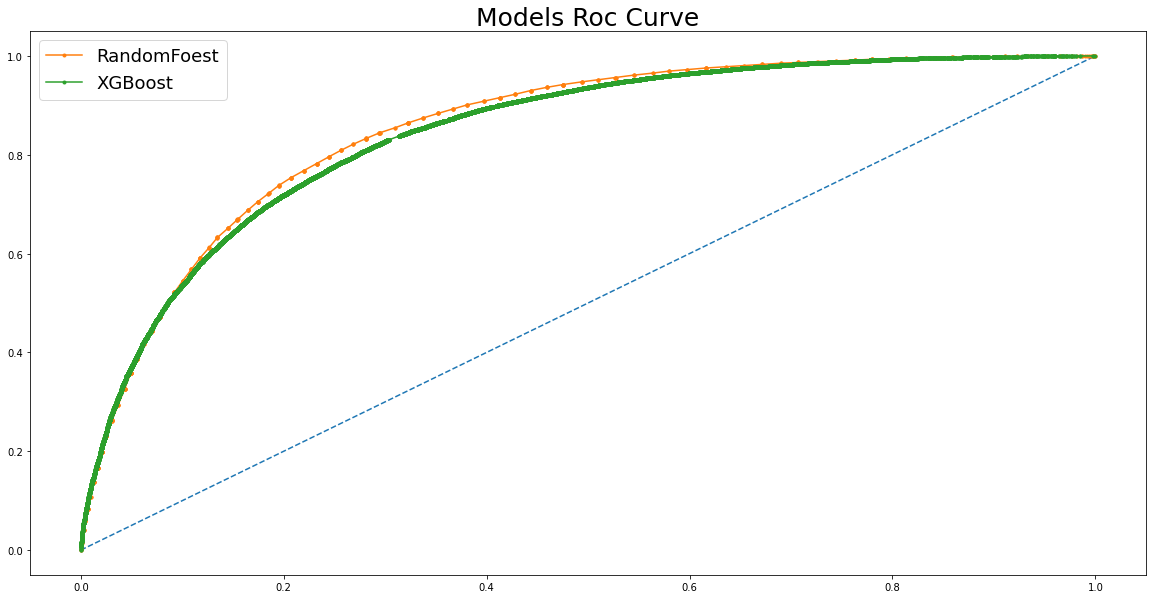

In [57]:
## 랜덤포레스트와 XGBoost 모델의 Roc_Curve
def rocvis(true , prob , label ) :
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )
    
   
fig , ax = plt.subplots(figsize= (20,10))
plt.plot([0, 1], [0, 1], linestyle='--')
rocvis(y_test_tf , rfc_proba[:,1] , "RandomFoest")
rocvis(y_test_tf , xgb_proba[:,1] , "XGBoost")
plt.legend(fontsize = 18)
plt.title("Models Roc Curve" , fontsize= 25)
plt.show()

데이터 불균형으로 인해 정확도에 비해 f1_score는 상대적으로 두 모델 다 높게 나오는 것을 볼 수 있다.
그래도 Auc_score를 확인해보면 0.5 ~ 1사이값을 가지는데, 0.52, 0.54로 나온다는 것은 일반화하기에 어려움이 있는 모델로 판단이 된다.
그리고 성능이 좋지 않게 나온 것은 아무래도, 5점은 긍정, 4점 이하를 부정으로 처리하는 부분에 있어서 세웠던 가설은 맞지 않아 성능이 좋지 않게 나온 것으로 유추된다. (모델이 별로였다기보다는 데이터 처리 과정에서 적합하지 않은 형태로 변형되었던 점)
_____________________________________________________________________________
## 배운 점
### 1.대략적으로 성능자체는 딥러닝 모델이나 앙상블 모델 큰 차이는 없지만, 딥러닝 모델의 시간이 너무 오래걸린다는 점에서 무조건적으로 딥러닝 모델이 NLP에 있어서 좋은 것만은 아닐 수도 있겠다라는 것을 몸소 느낄 수 있었다. 앞으로 NLP 모델링을 진행할 때, 머신러닝 모델도 꼭 같이 진행하여 비교해보는 습관을 길러나가야겠다.
### 2. 이전 프로젝트에서 제대로 된 EDA가 이루어 지지 않아, 성능은 높게 나왔으나 중복 데이터가 많은 이슈로 인해 신뢰할 수 없는 것을 보완하면서 확인할 수 있었다. EDA가 중요하다고는 들었지만, 그게 몸으로 와닿지는 않았지만 이번 계기로 인해 EDA가 왜 제대로 이루어져야하는지 새삼 깨달을 수 있었다. 
### 3. 불균형 데이터를 다루게 되는 경우가 앞으로도 많을텐데, 이를 보완할 수 있는 방법에 대해 많은 고민이 필요할 것 같다.

### BERT 감성 분석 모델 구현

In [45]:
#random seed 고정
tf.random.set_seed(411)
np.random.seed(411)
BATCH_SIZE = 512
NUM_EPOCHS = 5
VALID_SPLIT = 0.2
MAX_LEN=300

In [46]:
tokenizer=BertTokenizer.from_pretrained('bert-base-multilingual-cased',  cache_dir='bert_ckpt', do_lower_case=False)

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict=tokenizer.encode_plus(
    text = sent, 
    add_special_tokens=True, 
    max_length=MAX_LEN, 
    pad_to_max_length=True, 
    return_attention_mask=True,
    truncation = True)
    
    input_id=encoded_dict['input_ids']
    attention_mask=encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

input_ids =[]
attention_masks =[]
token_type_ids =[]
train_data_labels = []


for train_sent, train_label in zip(train['Text'], train['sentiment']):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN=MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids=np.array(input_ids, dtype=int)
train_attention_masks=np.array(attention_masks, dtype=int)
train_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
train_inputs=(train_input_ids, train_attention_masks, train_token_type_ids)
train_labels=np.asarray(train_data_labels, dtype=np.int32)

In [48]:
from transformers import BertTokenizer, TFBertModel

In [49]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope(): ## TPU 설정
    cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                    dir_path='bert_ckpt',
                                    num_class=1)

    # 학습 준비하기
    optimizer = tf.keras.optimizers.Adam(3e-6)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')
    cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model_name = "tf2_bert_classifier"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.0001,patience=10, restore_best_weights=True)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history_bert = cls_model.fit(train_inputs, train_labels, epochs=30, batch_size=64,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

INFO:tensorflow:Initializing the TPU system: grpc://10.70.40.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.70.40.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


tf2_bert_classifier -- Folder create complete 

Epoch 1/30


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int32>]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int32>]


4621/4621 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.7937

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=int32>]


4621/4621 [==============================] - 1144s 220ms/step - loss: 0.4337 - accuracy: 0.7937 - val_loss: 0.4461 - val_accuracy: 0.7805

Epoch 00001: val_loss improved from inf to 0.44612, saving model to tf2_bert_classifier/weights.h5
Epoch 2/30
4621/4621 [==============================] - 946s 205ms/step - loss: 0.3860 - accuracy: 0.8244 - val_loss: 0.4306 - val_accuracy: 0.7898

Epoch 00002: val_loss improved from 0.44612 to 0.43060, saving model to tf2_bert_classifier/weights.h5
Epoch 3/30
4621/4621 [==============================] - 946s 205ms/step - loss: 0.3657 - accuracy: 0.8363 - val_loss: 0.4208 - val_accuracy: 0.8076

Epoch 00003: val_loss improved from 0.43060 to 0.42081, saving model to tf2_bert_classifier/weights.h5
Epoch 4/30
4621/4621 [==============================] - 946s 205ms/step - loss: 0.3504 - accuracy: 0.8448 - val_loss: 0.4164 - val_accuracy: 0.8137

Epoch 00004: val_loss improved from 0.42081 to 0.41635, saving model to tf2_bert_classifier/weights.h5
Epoch 

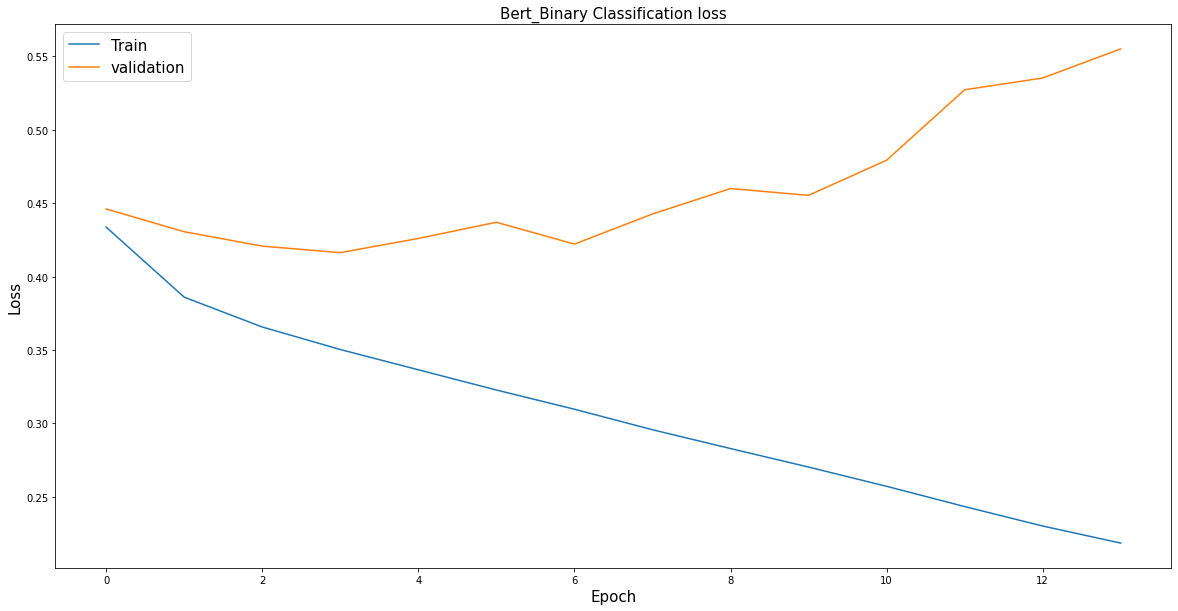

In [50]:
# Plot training & validation loss values
plt.figure(figsize = (20, 10))
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('Bert_Binary Classification loss', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

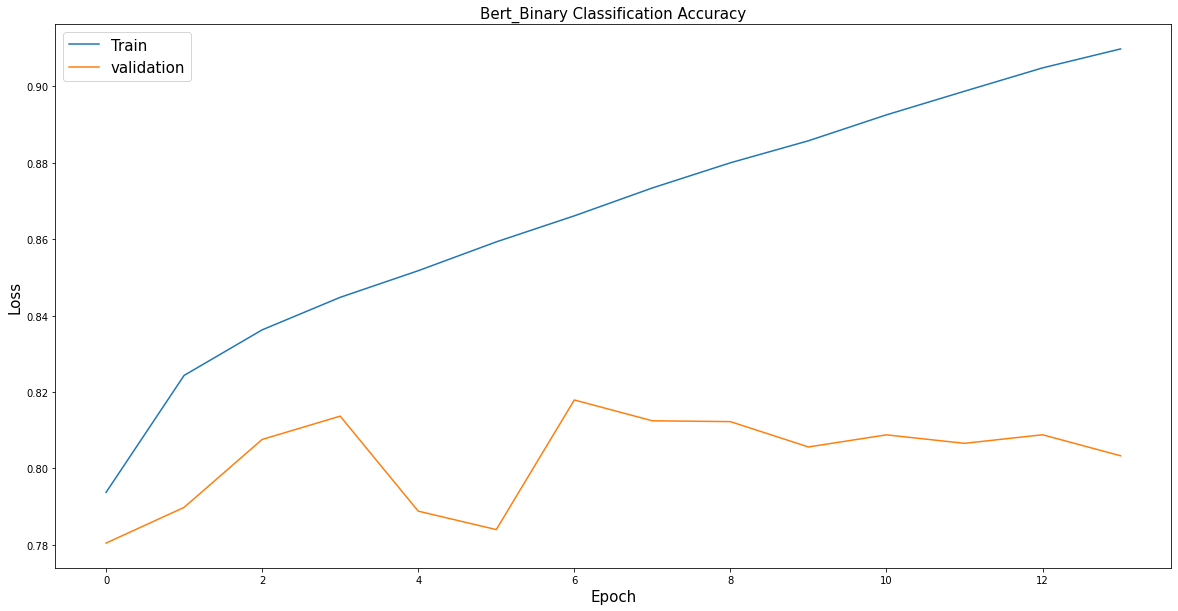

In [51]:
# Plot training & validation accuracy values
plt.figure(figsize = (20, 10))
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('Bert_Binary Classification Accuracy', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.legend(['Train', 'validation'], loc='upper left', fontsize = 15)
plt.show();

BERT의 성능이 LSTM 모델보다 개선이 이루어지

In [61]:
pip freeze > requirements.txt

학습 속도를 올리고, 학습을 안정적으로 진행하고자 Batch_size 256, 512로 진행했을 때, GPU 메모리 초과로 학습이 중단되었다. 그래서 128로 진행하니, 메모리 이상없이 학습을 진행할 수 있었다. 이 과정을 통해 학습 환경을 고려하여 배치 사이즈 설정이 필요하다는 점을 배울 수 있었다. 뿐만 아니라, 평소에 하둡이나 스파크와 같은 분산 컴퓨팅에 대해 단어만 들어왔었지, 이것이 단순하게 DB와 연관된 것이라고만 생각했었다. 하지만, 학습 환경에 있어서 분산컴퓨팅을 이용하여 여러 컴퓨터의 CPU와 GPU를 이용한다면 대량의 데이터를 학습할 수 있다는 것을 경험을 통해 깨달았다.
### 첫수정 내용
감성 분석을 위해 순환신경망인 LSTM 모델을 이용하였지만, 성능이 저조했다. 이를 개선하고자 tf-idf를 활용하여 앙상블 모델인 랜덤포레스트와 XGBoost 모델을 구현해보았다. 하지만, LSTM과 유사한 성능이 나왔다. 아무래도, 4점 이하를 부정, 5점을 긍정으로 나눈 것이 매우 비선형적인 문제여서 성능이 나오지 않았을까 하는 생각으로, 데이터가 적합하지 않았다는 것을 추론하였다. 근데, 실제 비즈니스에서도 이러한 요소를 고려한다면 똑같은 환경이나 다를 것이 없다고 생각했기에 제가 풀어보고자 하는 문제를 어떻게 하면 개선할 수 있을까 생각을 했다. 그렇다면, 사전학습이 된 모델에다가 fine-tuning을 진행하게 된다면 성능이 개선되지 않을까라는 생각을 했다. 그래서, NLP 분야에서 가장 핫한 BERT 모델을 구현해보기로 했다.
BERT 모델을 구현했지만, 대량의 데이터가 사전학습된 모델을 가지고 오는 것이다보니, 10번을 학습하게 되면 90일이 걸리는... 말도 안되는 시간이 나왔다. 그래서 colab-pro를 이용했음에도 불구하고 너무 오랜 시간이 걸리는 것에 포기를 할까라는 생각으로 마지막 구글링을 하던 중, 학습환경을 개선할 수 있는 부분을 확인하였다.
코랩 프로의 TPU의 학습 환경을 구성했지만, 실제 모델 학습에서는 GPU나 TPU를 사용하지 않고 했다는 점을 깨달았다. 그래서 코드로 TPU로 설정을 해주고 BERT를 구현한 결과, 학습 속도가 엄청나게 빨라지는 것을 확인했다.

### 두번째 수정 내용
다시 한번 수정을 진행하면서, 베이스 라인 모델인 LSTM의 early stopping의 patience를 5로 설정했을 때, 성능 개선되는 것을 확인하지 못하여 풀고자 하는 문제를 풀 수 없는 것이라 생각했다.
하지만 patience를 10으로 설정하여 다시 진행한 결과, local minima에 빠져있었던 것을 확인할 수 있었고, local minima에서 벗어나면서 성능이 개선되는 것을 확인할 수 있었다.

뿐만 아니라, 구글링하던 중 TF-IDF에서 특이값 분해가 아닌 chi2를 통해서 변수 선택을 하는 방법을 쓰는 것을 볼 수 있었다. 그래서 카이제곱검정을 활용해서 변수 선택을 진행한 결과, 성능이 기존의 0.63~0.64였던 것이 0.78까지 개선되는 것을 확인할 수 있었다. 하지만 카이제곱 검정이 종속 변수와 각각의 변수들을 일일이 상관성이 있는 것을 고르는 과정 때문인지 ML 모델 답지 않게 학습 시간이 4시간 이상 걸리는 것을 확인할 수 있었다. 이렇게 학습 시간이 오래걸린다면 TPU나 GPU를 쓸 수 있는 환경이 있다면 딥러닝 모델을 구현하는 것이 좋을 것으로 판단된다.

마지막으로, BERT 모델로 감성 분석을 진행한 결과 베이스라인 모델보다 근소한 차이로 성능이 높은 것을 확인할 수 있었다. 하지만 확실하게 차이점을 느낄 수 있었던 것은, pre-traning의 효과 때문인지 local minima에 빠지지 않고 첫 epochs부터 성능이 높았다는 것을 확인하였다. 이를 통해서 효율성은 확실하게 BERT가 베이스 라인 모델보다 좋다는 것을 느낄 수 있었다.

이 프로젝트를 통해 나는 학습한 것이 매우 많다.
1. EDA와 전처리의 중요성을 깨달았다. 사실, 그전에는 EDA와 전처리가 동일한 것이라고 생각했지만, EDA는 말 그대로, 데이터의 분포나 탐색을 하는 과정을 겪는 것이고, 그 과정들을 통해 데이터를 어떻게 처리를 해줄지 파악하여 전처리를 해주는 것이었다. 실제 모델 성능에 영향을 미치는 요소일 수 있다는 것을 느꼈다.
2. 한가지의 모델만을 사용하는 것이 아니라, 다양한 모델을 시도하는 것이 얼마나 중요한지 깨달았습니다. 가장 성능이 좋은 모델이 데이터에 따라달라질 수도 있기 때문에 시도해보고 성능을 지속적으로 개선하는 과정들이 필요한 것을 느꼈습니다.
3. 분산 처리 환경의 중요성과 학습을 진행할 때, GPU와 TPU를 사용하는 것이 중요하다는 것을 느꼈습니다. BERT의 경우, RNN기반의 모델 요소가 없기 때문에 병렬적으로 학습이 진행을 되기 때문에, GPU나 TPU를 잘 활용해야 한다는 것을 느꼈습니다.
4. 성능도 중요하지만, 내가 무엇을 풀고 싶은지가 더 중요하다고 생각합니다. 성능은 말 그대로 결과일 뿐이지, 문제를 어떻게 정의하는 것이 더 중요합니다. 저는 4점 이하의 경우, 문맥에서 부정적인 요소가 나타날 것이라는 가설을 세우고 그러한 단어가 나타나면 부정으로 분류, 부정적인 내용이 전혀 없다면 5점으로 분류하는 모델을 구현했습니다. 누군가에게 해당 프로젝트가 성공을 했는지 물어봤을 때, 성능이 90%나 나왔어요 라고 말하는 것보다 이러한 문제를 정의했고, 이것을 예측하는 하기 위해 모델을 구현했을 때 성능이 90%가 나왔기 때문에 일반화할 수 있는 모델이라고 판단하였다라는게 더욱 설득력이 있다고 생각한다.